### Imports

In [1]:
%load_ext autoreload
%autoreload 2

import os

import numpy as np

from mynn.neural_network import NeuralNetwork
from mynn.layers import Layer
from unsupervised_learning.algorithms import MountainClustering, FuzzCMeans
from anfis.anfis import ANFIS
from anfis.membership.membershipfunction import MemFuncs

from mynn.utils import train_model
from helper_functions.data_management import data_loading, joint_random_sampling
from helper_functions.plotting import plot_training_history, color_plot, plot3d_dataset, plot_embedding

### Auxiliary Functions

In [2]:
def create_autoencoder(num_features: int, num_hidden_units: int, learning_rate: float):

    autoenconder = NeuralNetwork(
        layers=[
            Layer(num_features, num_hidden_units, activation="sigmoid", include_bias=True),
            Layer(num_hidden_units, num_features, activation="sigmoid", include_bias=True),
        ],
        learning_rate=learning_rate,
        loss="cuadratic",
    )

    return autoenconder

def get_autoencoder_embedding(trained_autoencoder: NeuralNetwork, inputs: np.ndarray):

    autoencoder_layers = trained_autoencoder.layers
    encoding_layer = autoencoder_layers[0]

    return encoding_layer.forward(inputs)

def get_mountain_membership_function(centers, destructive_parameter):

    membership_function = []
    for cluster_dimension in centers.T:
        dim_membership_function = []
        for cluster_mean in cluster_dimension:
            dim_membership_function.append(["gaussmf", {"mean": cluster_mean, "sigma": destructive_parameter}])
        membership_function.append(dim_membership_function)

    return membership_function

def get_fuzzy_membership_function(centers, sigmas):

    membership_function = []
    for cluster_dimension in centers.T:
        dim_membership_function = []
        for cluster_num, cluster_mean in enumerate(cluster_dimension):
            dim_membership_function.append(["gaussmf", {"mean": cluster_mean, "sigma": sigmas[cluster_num]}])
        membership_function.append(dim_membership_function)

    return membership_function

### Data loading

In [3]:
manip_category = 'wash_trade'
energy_threshold = 0.5
use_cone = False
root_folder_path = os.path.dirname(os.getcwd())

manip_features = data_loading(root_folder_path, manip_category, energy_threshold, use_cone)

### Visualization

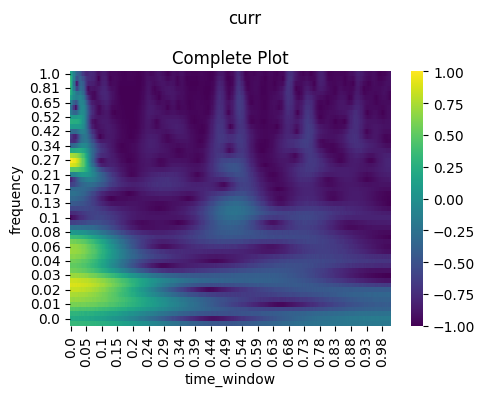

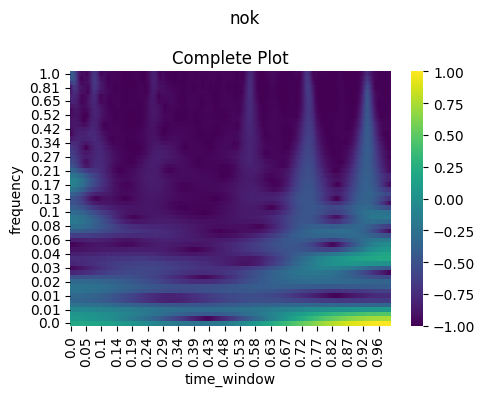

In [4]:
for stock_name, stock_dict in manip_features.items():
    color_plot(stock_dict, stock_name)

### 3d Visualization

In [5]:
stock_name = 'nok'
plot_against = 'frequency'
hue_var = 'target'
feature_matrix = manip_features[stock_name]['features']

plot3d_dataset(feature_matrix, stock_name, plot_against, hue_var)

### Train autoencoder and get embedding

Epoch 1/3 | Loss: 0.001994263145996375
Epoch 2/3 | Loss: 0.0013468068554629772
Epoch 3/3 | Loss: 0.0013913149355541743


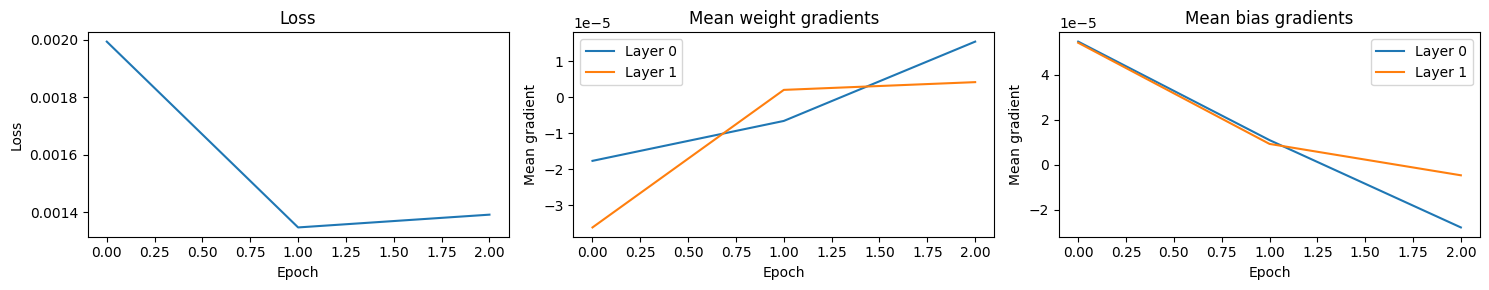

In [6]:
feature_matrices = [
    stock_dict['features'][:, :-2]
    for _, stock_dict in manip_features.items()
]

stacked_feature_matrix = np.vstack(feature_matrices)

autoencoder = create_autoencoder(num_features=stacked_feature_matrix.shape[1], num_hidden_units=2, learning_rate=1)

trained_autoencoder, train_history, _, _ = train_model(
    autoencoder, stacked_feature_matrix, stacked_feature_matrix, num_epochs=3, batch_size=1, verbose=True
)

plot_training_history(train_history, True, stacked_feature_matrix.shape[0])

### Sampling

In [7]:
percentage_to_sample = 5000 / stacked_feature_matrix.shape[0]
train_x_all, train_y, val_x_all, val_y, test_x_all, test_y = joint_random_sampling(manip_features, percentage_to_sample, 0.5, 'uniform', False)

train_x = train_x_all[:, :-1]
train_modulus = train_x_all[:, -1]
val_x = val_x_all[:, :-1]
val_modulus = val_x_all[:, -1]
test_x = test_x_all[:, :-1]
test_modulus = test_x_all[:, -1]

### Plot 3d results of sampled dataset

In [8]:
plot_against = 'frequency'
hue_var = 'modulus'

plot3d_dataset(np.concatenate([train_x_all, train_y.reshape(-1, 1)], axis=1),
                f'{manip_category} - Sampled Dataset',
                plot_against,
                hue_var)

### Get embeddings

In [9]:
train_embedding = get_autoencoder_embedding(trained_autoencoder, train_x.T).T
val_embedding = get_autoencoder_embedding(trained_autoencoder, val_x.T).T
test_embedding = get_autoencoder_embedding(trained_autoencoder, test_x.T).T

### Plot embeddings

In [10]:
plot_embedding(np.hstack([train_embedding, train_modulus.reshape(-1, 1), train_y.reshape(-1, 1)]),
                f'{manip_category} - Embedding Sampled Dataset',
                hue_modulus=True)

### ANFIS

#### Mountain Clustering

In [11]:
sigma_squared = 1.1
beta_squared = sigma_squared*1.5
mountain_clustering = MountainClustering(number_of_partitions=20,
                                        distance_metric='euclidean',
                                        sigma_squared=sigma_squared,
                                        beta_squared=beta_squared,)

mountain_clustering.fit(train_embedding)

MountainClustering(beta_squared=1.6500000000000001, number_of_partitions=20,
                   sigma_squared=1.1)

In [17]:
mountain_cluster_assignments = mountain_clustering.predict()

plot_embedding(np.hstack([train_embedding, train_modulus.reshape(-1, 1), mountain_cluster_assignments]),
                f'{manip_category} - Embedding Sampled Dataset',
                hue_modulus=False)

##### ANFIS fitting and prediction

In [13]:
# Get unique centers
fuzzy_centers = np.unique(mountain_clustering.centers_, axis=0)

# Get membership functions
mountain_membership_function = MemFuncs(get_mountain_membership_function(fuzzy_centers, beta_squared))

# Instance anfis object and train it
mountain_anfis = ANFIS(train_embedding, train_modulus, mountain_membership_function)
x_pred = mountain_anfis.trainHybridJangOffLine(epochs=50)

current error: 487.10956628674666
current error: 478.6318366548229
current error: 470.68217317069707
current error: 463.2621649610713
current error: 455.65721303131767
current error: 447.9292593851404
current error: 440.1390334887264
current error: 432.34570457996244
current error: 424.6064745859096
current error: 416.9760883315701
current error: 409.50627411565085
current error: 402.2451429566633
current error: 395.23657977884307
current error: 388.51966039716524
current error: 382.12812589829616
current error: 376.0899424686775
current error: 370.4269702958434
current error: 365.15475957496824
current error: 360.28248577184524
current error: 355.81302977499945
current error: 351.74320189319405
current error: 348.0641020350665
current error: 344.76160200747245
current error: 341.8169295047858
current error: 339.20732703536964
current error: 336.90675146277033
current error: 334.8865697698735
current error: 333.11619095116635
current error: 331.5635476711351
current error: 330.19529548

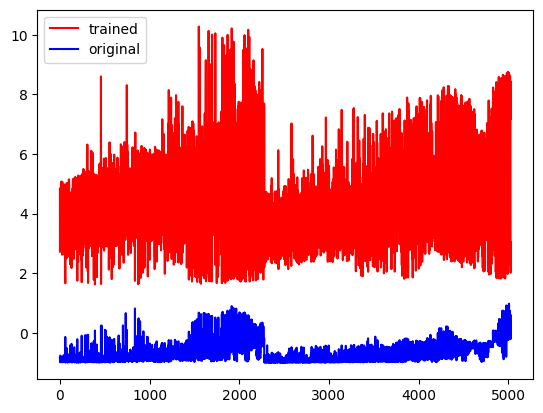

In [14]:
mountain_anfis.plotResults()

#### Fuzzy C Means

In [13]:
fuzzycmeans = FuzzCMeans(number_of_clusters=4,
                        fuzzines_parameter=2,
                        distance_metric='euclidean',
                        n_iter=1000,
                        verbose=False,)
fuzzycmeans.fit(train_embedding)

FuzzCMeans(number_of_clusters=4)

In [16]:
fuzzy_cluster_assignments = fuzzycmeans.predict().argmax(axis=1).reshape(-1, 1)

plot_embedding(np.hstack([train_embedding, train_modulus.reshape(-1, 1), fuzzy_cluster_assignments]),
                f'{manip_category} - Embedding Sampled Dataset',
                hue_modulus=False)

In [17]:
sigmas = fuzzycmeans.predict().std(axis=0).tolist()

# Get membership functions
fuzzy_membership_function = MemFuncs(get_fuzzy_membership_function(fuzzycmeans.centers_, sigmas))

# Instance anfis object and train it
fuzzy_anfis = ANFIS(train_embedding, train_modulus, fuzzy_membership_function)
fuzzy_x_pred = fuzzy_anfis.trainHybridJangOffLine(epochs=50)

current error: 258.8169695067296
current error: 248.9831130472141
current error: 244.714181540165
current error: 242.31338933040473
current error: 240.4635596427996
current error: 238.8254061216398
current error: 237.16512191163855
current error: 235.26709955199976
current error: 232.95951735528044
current error: 230.2304926330218
current error: 227.31083213308696
current error: 224.51257721937594
current error: 221.6896484542425
current error: 218.00786467634993
current error: 212.61328514956335
current error: 232.7827394315767
current error: 220.30426547467053
current error: 212.24157206953572
current error: 207.2357484444368
current error: 204.2271408617102
current error: 208.4222324338976
current error: 208.1871471634804
current error: 204.9285222281547
current error: 203.104087340386
current error: 207.7915901614964
current error: 205.44288124922485
current error: 203.7878777172018
current error: 207.39468960377485
current error: 204.3458018758106
current error: 202.38988174176632

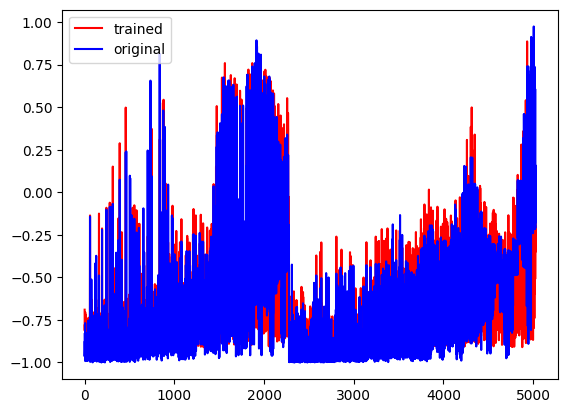

In [18]:
fuzzy_anfis.plotResults()